#Overview

Analysis of cyclic experiments by tracking of the first cycle: the idea is, that only the first cycle gets tracked which serves as a reference for the local strain map and the constructed reference force. Subsequently, all other cycles get cut at the same pre-force (matching to the first reference) and the local strain values get interpolated using information of the tracking of the first cycle and current positioning of the clamp.

Short: Sensor force-displacement data is approximately scaled to stress-strain data, based on 1 "known" cycle. Cheeky.

In [1]:
# magics
%load_ext autoreload
%autoreload 2
%matplotlib inline

# custom modules and settings
from __future__ import division
from ldm.helper import cut_cycles_at_value, branch_split

# modules
import numpy as np
import os, glob

# plotting
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
fp = {'family':'serif', 'serif':['Helvetica'], 'size':'20'}
rc('font', **fp)
rc('text',  usetex=True)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

# plot scaling
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.grid'] = True

#Load Data

##Experiment

In [2]:
# path and load data
basepath = '/media/rhopf/phd_home/b_zurich_heart/a_experiments/V_UA_PDMS_s2_test1/'
time_mts, u1, f1, u2, f2  = np.loadtxt(os.path.join(basepath, 'mts/ua_monotonic.dat'), skiprows=5).T

# process mts sensor data
displ = u1 + u2
force = (f1 + f2)/2.0

# specimen geometry file
width, t1, t2, t3 = np.loadtxt(basepath + 'geometry.dat').T

# process geometry file
width     = np.mean(width)
thickness = (np.mean(t1) + np.mean(t2) + np.mean(t3))/3.0
csarea    = width*thickness

##Reference Cycle

In [3]:
# index of cycle that used to evaluate local strains
i_cycle  = 2

# reference cycle
cycfile  = '/media/rhopf/phd_home/b_zurich_heart/a_experiments/analysis/V_UA_PDMS_s2_test1_cycle_2.dat'
epsx, epsy, sig_pk1, sig_cau  = np.loadtxt(cycfile).T

# load preforce
preforce = np.loadtxt('/media/rhopf/phd_home/b_zurich_heart/a_experiments/analysis/V_UA_PDMS_s2_test1_cycle_2_config/preforce.dat')
preforce = float(preforce)
print 'Preforce =', preforce, 'N'

Preforce = 0.155365745 N


#Process Data

In [4]:
k = cut_cycles_at_value(force, preforce, cd_dist=50)
print 'Number of cycles recorded:', len(k)

plt.figure(figsize=(16, 7))
plt.plot(time_mts, displ/displ.max(), 'b')
plt.plot(time_mts, force/force.max(), 'r')
[plt.plot(time_mts[ki], displ[ki]/displ.max(), 'bo', ms=4) for ki in k]
[plt.plot(time_mts[ki], force[ki]/force.max(), 'ro', ms=4) for ki in k]
plt.title('Cycle extraction')
plt.xlabel('time [s]')
plt.ylabel('force [N]')

Number of cycles recorded: 7


In [5]:
plt.plot(displ, force)

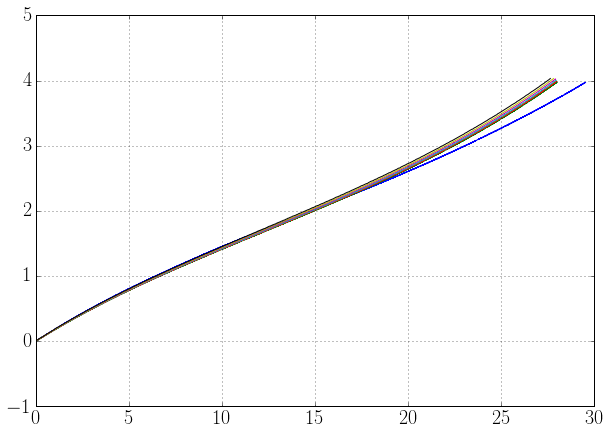

In [6]:
# collect branches and interpolate data
f_ld = []
u_ld = []
eps  = []
sig  = []

for ki in k:
    u = displ[ki[0]:ki[1]]
    f = force[ki[0]:ki[1]]
    
    idx_split = np.argmax(f)
    u_l, _    = branch_split(idx_split, u)
    f_l, _    = branch_split(idx_split, f)
    
    # shift
    u_l = u_l - u_l[0]
    f_l = f_l - f_l[0]
    
    # append lists
    u_ld.append(u_l)
    f_ld.append(f_l)

# scaling factor for global displacement to local strain (ensure that cycles correspond!)
sfac = epsx[-1]/u_ld[i_cycle-1][-1]
    
for u, f in zip(u_ld, f_ld):
    plt.plot(u, f)
    
    # scale global displacement to local strain
    epsi = u*sfac
    csarea_current = csarea/(epsi+1)
    sigi = f/(csarea_current)
    
    eps.append(epsi)
    sig.append(sigi)

In [8]:
# plot cycles
n = 1
# plot the rest
# plt.plot(epsx, sig_cau, 'r', lw=2, label='ref. cycle\t\tat\t10 [\%/min]')

for i, (x, y) in enumerate(zip(eps[(i_cycle-1):], sig[(i_cycle-1):])):
    plt.plot(x, y, color=str(i/(len(eps[n:])+2)), lw=1, label=r'$\dot{\varepsilon} =$ ' +
                                                              str(10*2**(i+1)) + ' [\%/min]')

    
# annotation
plt.annotate("increasing strain rate", fontsize=18,
            xy=(0.4, 0.8), xycoords='data',
            xytext=(0.4, 0.45), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3"),
            )

# format axes
plt.ylim([0, 1.2])
plt.xlabel('strain [-]', fontsize=20)
plt.ylabel('Cauchy stress [MPa]', fontsize=20)
plt.legend(loc='best', fontsize=18, fancybox=True, framealpha=0.5)
plt.tick_params(labelsize=18, labelcolor='k')
plt.tick_params(axis='x', pad=6)
plt.tick_params(axis='y', pad=6)

plt.savefig('/home/rhopf/Dropbox/b_zurich_heart/c_models/alex/to_plot/figure5/strain_rate_dependence.jpg')

# Save Data 

In [ ]:
for i, (x, y) in enumerate(zip(eps[1:], sig[1:])):
    np.savetxt('/media/rhopf/phd_home/b_zurich_heart/a_experiments/final/V_UA_PDMS_cycle_' + str(i+1) + '.dat', np.array([x, y]).T)